In [1398]:
import pandas as pd
from print_nanny_webapp.client_events.models import PredictEvent
from django.utils import timezone
from asgiref.sync import sync_to_async
import os

import matplotlib


In [1399]:
CONFIDENCE_THRESHOLD = 0.50

LABELS = {
    1: 'nozzle',
    2: 'adhesion',
    3: 'spaghetti',
    4: 'print',
    5: 'raft',
}

FAILURES = {
    2: 'adhesion',
    3: 'spaghetti',  
}


In [1400]:
import json
def dict_to_series(data):
    return pd.Series(data.values(), index=data.keys())

In [1401]:
predict_events = PredictEvent.objects.all().order_by('-dt').values('id','predict_data')

df = pd.DataFrame.from_records(predict_events, index='id')
df = df['predict_data'].apply(json_to_series)

NUM_DETECTIONS = len(df['detection_scores'].iloc[0])
print(NUM_DETECTIONS)

40
<ipython-input-343-5050ed11c4e8>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series(data.values(), index=data.keys())


In [1402]:
df = df.dropna()
df = df[['detection_classes', 'detection_scores']]
df = df.reset_index()
df = df.rename(columns={'id': 'frame_id' })

NUM_FRAMES = len(df)
df

,frame_id,detection_classes,detection_scores
0,118,"[4, 4, 1, 1, 1, 1, 3, 1, 1, 4, 4, 1, 1, 1, 4, ...","[0.12109375, 0.06640625, 0.03515625, 0.0351562..."
1,117,"[5, 4, 4, 4, 1, 1, 1, 5, 1, 2, 4, 4, 1, 1, 4, ...","[0.41796875, 0.02734375, 0.01953125, 0.0195312..."
2,116,"[4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 3, 1, 1, 1, 1, ...","[0.41796875, 0.06640625, 0.06640625, 0.0351562..."
3,115,"[4, 1, 1, 1, 4, 1, 1, 4, 4, 4, 1, 1, 1, 4, 4, ...","[0.16015625, 0.05078125, 0.03515625, 0.0351562..."
4,114,"[4, 4, 4, 1, 4, 1, 4, 4, 4, 1, 4, 4, 4, 4, 3, ...","[0.08984375, 0.05078125, 0.02734375, 0.0273437..."
...,...,...,...
111,7,"[4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 1, 4, ...","[0.33984375, 0.16015625, 0.12109375, 0.0664062..."
112,6,"[4, 4, 4, 4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.26953125, 0.2109375, 0.2109375, 0.12109375,..."
113,5,"[4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.41796875, 0.26953125, 0.16015625, 0.0664062..."
114,4,"[4, 4, 4, 4, 4, 4, 1, 1, 1, 4, 1, 4, 1, 1, 1, ...","[0.26953125, 0.2109375, 0.16015625, 0.08984375..."


In [1403]:
print('Explode detection_classes and detection_scores together')
df = df.set_index(['frame_id']).apply(pd.Series.explode).reset_index()

assert len(df) == NUM_FRAMES * NUM_DETECTIONS
df

Explode detection_classes and detection_scores together


,frame_id,detection_classes,detection_scores
0,118,4,0.121094
1,118,4,0.0664062
2,118,1,0.0351562
3,118,1,0.0351562
4,118,1,0.0351562
...,...,...,...
4635,3,1,0.0195312
4636,3,4,0.0195312
4637,3,4,0.0195312
4638,3,1,0.0195312


In [1404]:
print('Add labels')
df['label'] = df['detection_classes'].map(LABELS)
df


Add labels


,frame_id,detection_classes,detection_scores,label
0,118,4,0.121094,print
1,118,4,0.0664062,print
2,118,1,0.0351562,nozzle
3,118,1,0.0351562,nozzle
4,118,1,0.0351562,nozzle
...,...,...,...,...
4635,3,1,0.0195312,nozzle
4636,3,4,0.0195312,print
4637,3,4,0.0195312,print
4638,3,1,0.0195312,nozzle


In [1405]:
print('Create a hierarchal index')
df = df.set_index(['frame_id', 'label'])
df

Create a hierarchal index


detection_classes detection_scores
frame_id label                                    
118      print                  4         0.121094
         print                  4        0.0664062
         nozzle                 1        0.0351562
         nozzle                 1        0.0351562
         nozzle                 1        0.0351562
...                           ...              ...
3        nozzle                 1        0.0195312
         print                  4        0.0195312
         print                  4        0.0195312
         nozzle                 1        0.0195312
         print                  4        0.0117188

[4640 rows x 2 columns]

Distribution of confidences


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'nozzle'}>],
       [<AxesSubplot:title={'center':'print'}>,
        <AxesSubplot:title={'center':'raft'}>],
       [<AxesSubplot:title={'center':'spaghetti'}>, <AxesSubplot:>]],
      dtype=object)

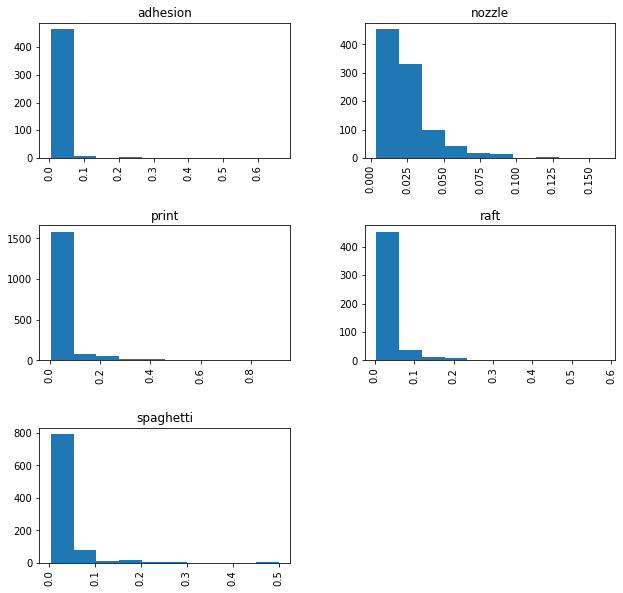

In [1406]:
print(f'Distribution of confidences')
df['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidences > 0.5


array([[<AxesSubplot:title={'center':'adhesion'}>,
        <AxesSubplot:title={'center':'print'}>],
       [<AxesSubplot:title={'center':'raft'}>, <AxesSubplot:>]],
      dtype=object)

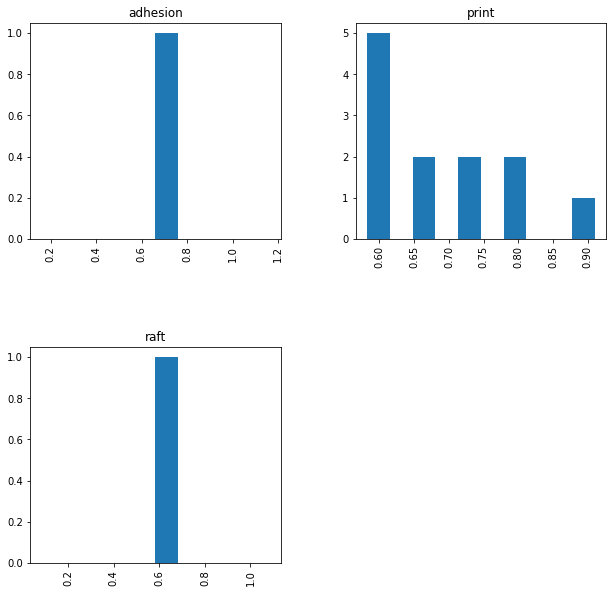

In [1407]:
print(f'Distribution of confidences > {CONFIDENCE_THRESHOLD}')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by='label', figsize=(10,10))

Distribution of confidence scores > THRESHOLD, FAILURE vs. OK


array([<AxesSubplot:title={'center':'FAILURE'}>,
       <AxesSubplot:title={'center':'NEUTRAL'}>], dtype=object)

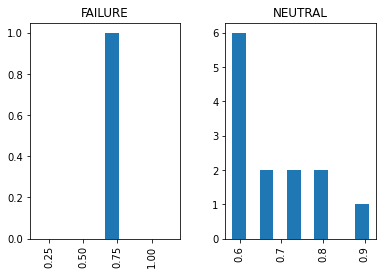

In [1408]:
print('Distribution of confidence scores > THRESHOLD, FAILURE vs. OK')
df[df['detection_scores'] > CONFIDENCE_THRESHOLD]['detection_scores'].hist(by=lambda x: 'FAILURE' if x[1] in FAILURES.values() else 'NEUTRAL' )


In [1409]:
print('Frames where at least 1 type of failure is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (df['detection_classes'].isin(FAILURES))

fail_df = df[mask]

fail_df

Frames where at least 1 type of failure is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
94,adhesion,2,0.660156


In [1410]:
print('Percent of frames where at least 1 type of failure is confidently detected')
(len(fail_df) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of failure is confidently detected


0.8620689655172413

In [1411]:
print('Frames where at least 1 type of neutral is confidently detected')

mask = (df['detection_scores'] > CONFIDENCE_THRESHOLD) & (~df['detection_classes'].isin(FAILURES))

neutral_df = df[mask]

neutral_df 

Frames where at least 1 type of neutral is confidently detected


,,detection_classes,detection_scores
frame_id,label,,
86,print,4,0.582031
85,print,4,0.582031
84,print,4,0.660156
81,print,4,0.660156
77,raft,5,0.582031
62,print,4,0.582031
59,print,4,0.582031
47,print,4,0.582031
34,print,4,0.789062


In [1412]:
print('Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected')
(len(neutral_df ) / NUM_FRAMES) * 100

Percent of frames where at least 1 type of neutral (print, raft, nozzle) is confidently detected


11.206896551724139